## Table of Contents

* [Import Libraries](#import)
* [Load Data](#load)
* [Data Overview](#overview)
* [Data Visualization](#visual)
* [Data Cleaning](#cleaning)
* [Preprocessing Pipeline](#pipe)
* [Model-1 Xgboost](#model1)
* [Model-2 Random Forest](#model2)
* [Model-3 Svm](#model3)
* [Model-4 Decision Tree Classifier](#model4)
* [Model Performance Comparison](#comparison)
* [Prepare Test Data](#test)
* [Test Prediction and Submission](#submission)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


## Import Libraries  <a class="anchor" id="import"></a>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MultiLabelBinarizer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from xgboost import XGBClassifier
import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

## Load Data <a class="anchor"  id="load"></a>

In [3]:
sample=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv')
train=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

## Data Overview <a class="anchor"  id="overview"></a>

In [4]:
train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [5]:
categorical_cols = ['Location', 'Cross_Street', 'Area_Name', 'Modus_Operandi', 'Victim_Sex', 
                       'Victim_Descent', 'Premise_Description', 'Weapon_Description', 'Status', 
                       'Status_Description', 'Crime_Category']
numerical_cols = ['Latitude','Longitude','Time_Occurred','Area_ID','Reporting_District_no','Part 1-2','Victim_Age',
                  'Premise_Code','Weapon_Used_Code']

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [7]:
missing_values = train.isnull().sum()
missing_percentage = (missing_values / len(train)) * 100
print(missing_percentage)

Location                  0.000
Cross_Street             82.760
Latitude                  0.000
Longitude                 0.000
Date_Reported             0.000
Date_Occurred             0.000
Time_Occurred             0.000
Area_ID                   0.000
Area_Name                 0.000
Reporting_District_no     0.000
Part 1-2                  0.000
Modus_Operandi           13.705
Victim_Age                0.000
Victim_Sex               13.120
Victim_Descent           13.120
Premise_Code              0.000
Premise_Description       0.025
Weapon_Used_Code         63.325
Weapon_Description       63.325
Status                    0.000
Status_Description        0.000
Crime_Category            0.000
dtype: float64


In [8]:
train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


**Observations**

**Geographical Distribution**:
   - The latitude values range from 0 to 34.3281, with a mean of approximately 33.9407. 
   - The longitude values range from -118.6634 to 0, with a mean of about -117.8931.
   - These values indicate that the incidents are mostly occurring in a specific geographical area, and 0 is possibly an outlier

**Time of Occurrence**:
   - The time of occurrence ranges from 1 to 2359, with a mean of approximately 1352.38.
   - The distribution suggests incidents occur throughout the day, with a possible peak around early afternoon.

**Crime Type (Part 1-2)**:
   - The Part 1-2 category indicates the type of crime, with values of 1 or 2.
   - The mean value of 1.4181 suggests that there may be a slightly higher number of Part 1 crimes compared to Part 2.

**Victim Age**:
   - The victim's age ranges from -2 to 99, with a mean age of approximately 30.14.
   - The minimum value of -2 indicate erroneous data entries.
   - The age distribution suggests that most victims are adults, with a median age of 31.

In [9]:
train[categorical_cols].describe(include='object')

,Location,Cross_Street,Area_Name,Modus_Operandi,Victim_Sex,Victim_Descent,Premise_Description,Weapon_Description,Status,Status_Description,Crime_Category
count,20000,3448,20000,17259,17376,17376,19995,7335,20000,20000,20000
unique,12399,1495,21,10489,4,17,216,57,5,5,6
top,6TH,BROADWAY,77th Street,0344,M,H,STREET,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
freq,33,56,1345,826,8538,6143,5033,3990,15236,15236,11666


## Data Visualition <a class="anchor"  id="visual"></a>

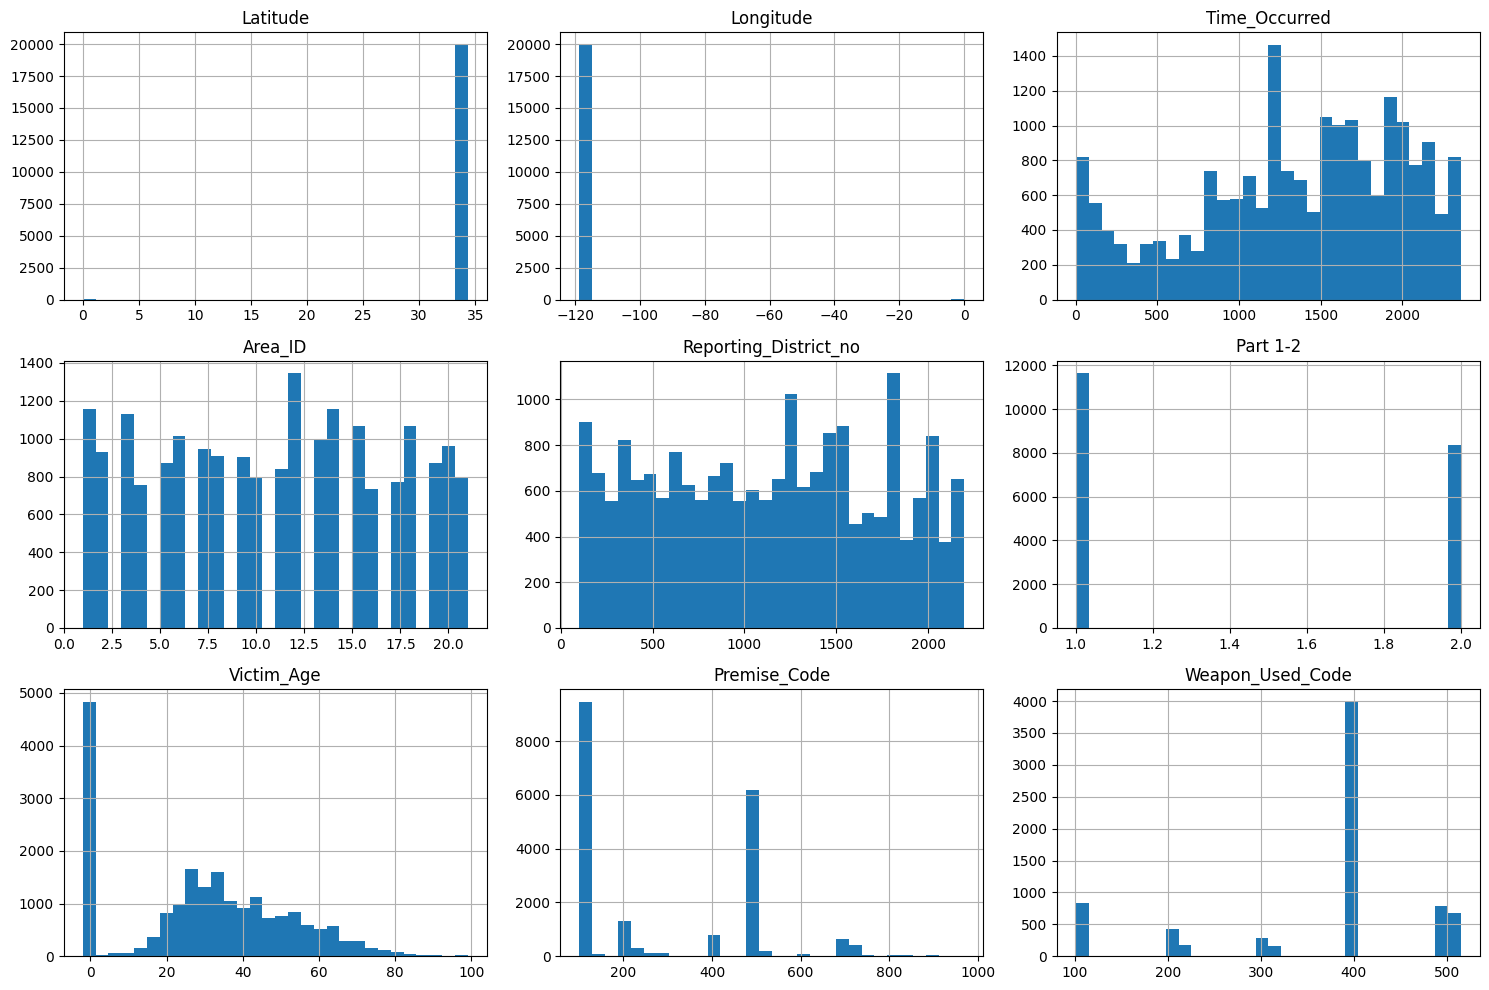

In [10]:
train.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

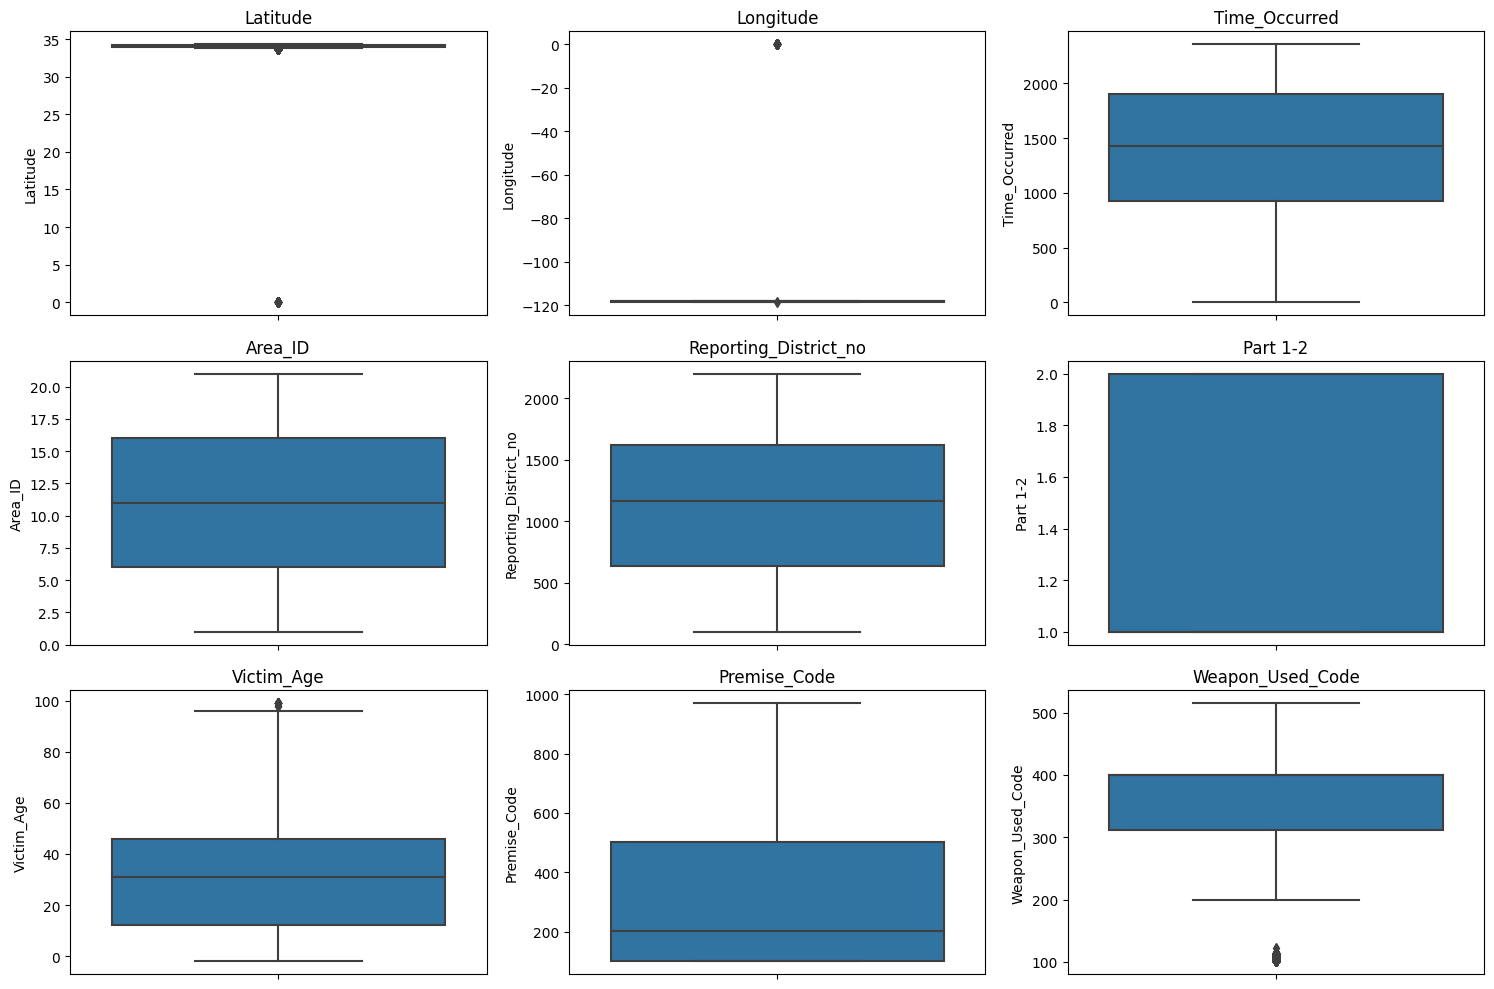

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=train[col])
    plt.title(col)
plt.tight_layout()
plt.show()

**Observations**

1. **Geographical Data**:
   - The tight clustering of latitude and longitude suggests that the data pertains to a specific city or region. The outliers need to be cleaned

2. **Temporal Patterns**:
   - The time of day seems to play a significant role in the occurrence of crimes, with higher incidents in the late afternoon and early evening.

3. **Spatial Distribution**:
   - There is no significant clustering of crimes in any specific area based on the Area ID, suggesting a fairly even distribution across the city.

4. **Victim Demographics**:
   - Younger individuals are more frequently victims of crimes. This could suggest higher vulnerability or exposure among younger age groups.

5. **Premise and Weapon Usage**:
   - Certain premises and weapons are more commonly associated with crimes, which could provide insights into common crime settings and methods.

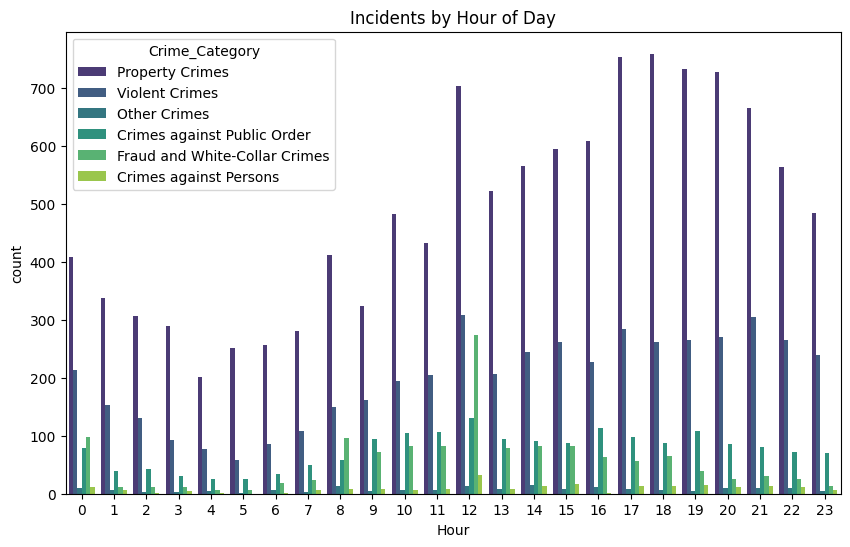

In [12]:
 train['Hour'] = train['Time_Occurred'].apply(lambda x: int(x // 100))

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=train, hue='Crime_Category', palette='viridis')
plt.title('Incidents by Hour of Day')
plt.show()
train = train.drop('Hour', axis=1)


**Time-Dependent Patterns:**

Property crimes peak during times when homes are likely unoccupied, indicating potential opportunities for burglary or theft. Violent crimes and crimes against persons show less time dependence

[33 32 31 31 30 29 25 25 24 23]
Index(['6TH', '7TH', 'VERMONT                      AV',
       '6TH                          ST', '7TH                          ST',
       '800 N  ALAMEDA                      ST',
       '4TH                          ST', 'HOLLYWOOD',
       '10200    SANTA MONICA                 BL', '5TH'],
      dtype='object', name='Location')


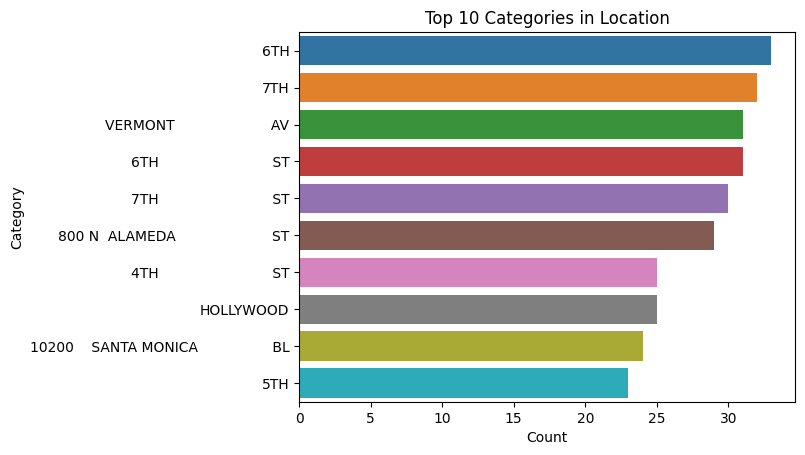

[56 43 40 34 33 30 28 26 25 23]
Index(['BROADWAY', 'FIGUEROA', 'VERMONT                      AV',
       'FIGUEROA                     ST', 'MAIN',
       'MAIN                         ST', 'SAN PEDRO',
       'SAN PEDRO                    ST', 'WESTERN                      AV',
       'WILSHIRE'],
      dtype='object', name='Cross_Street')


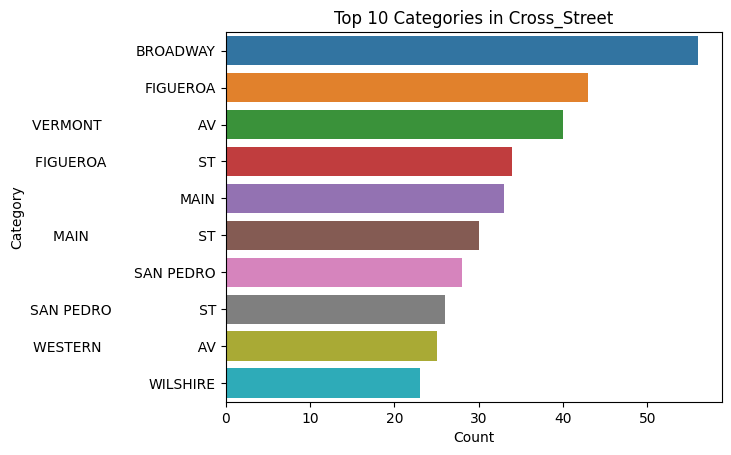

[1345 1157 1156 1130 1067 1065 1014  999  960  943]
Index(['77th Street', 'Pacific', 'Central', 'Southwest', 'Southeast',
       'N Hollywood', 'Hollywood', 'Newton', 'Olympic', 'Wilshire'],
      dtype='object', name='Area_Name')


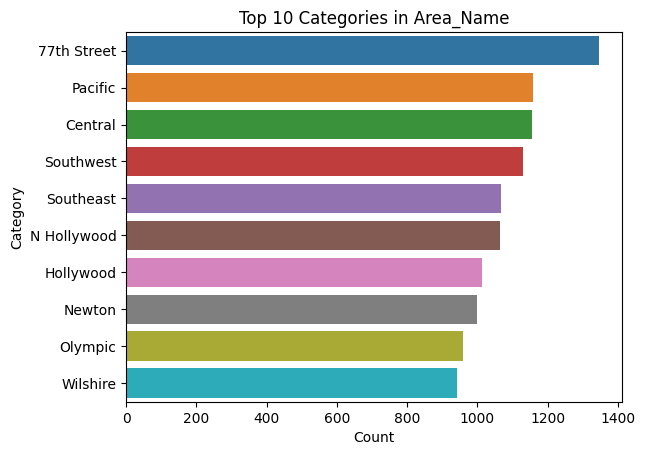

[826 583 187 135 127 114 108 108 103  97]
Index(['0344', '0329', '1501', '0329 1300', '0325', '0344 1300', '0344 1822',
       '1822 0344', '0329 1822', '0344 0394'],
      dtype='object', name='Modus_Operandi')


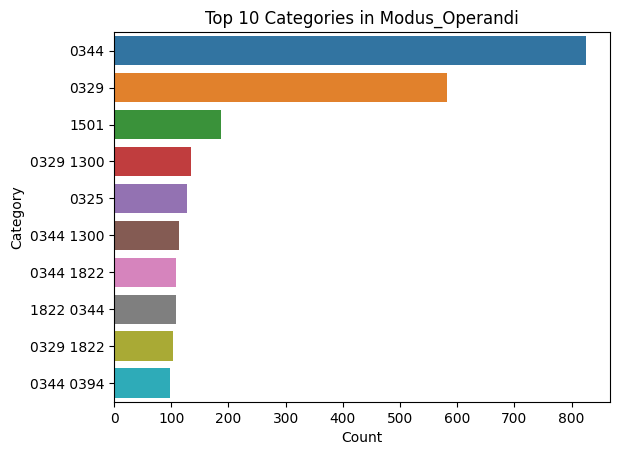

[8538 7176 1660    2]
Index(['M', 'F', 'X', 'H'], dtype='object', name='Victim_Sex')


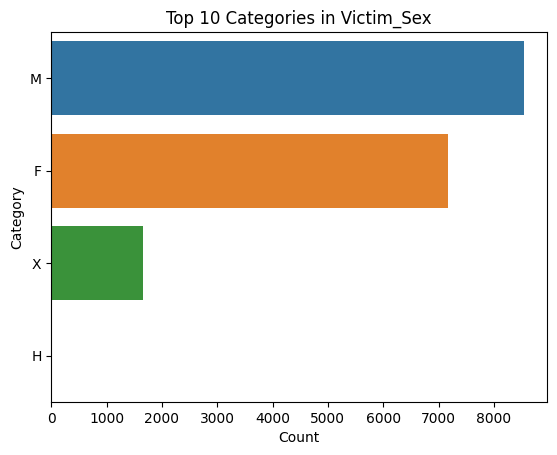

[6143 4245 2881 1849 1603  427   83   51   48   16]
Index(['H', 'W', 'B', 'X', 'O', 'A', 'K', 'C', 'F', 'J'], dtype='object', name='Victim_Descent')


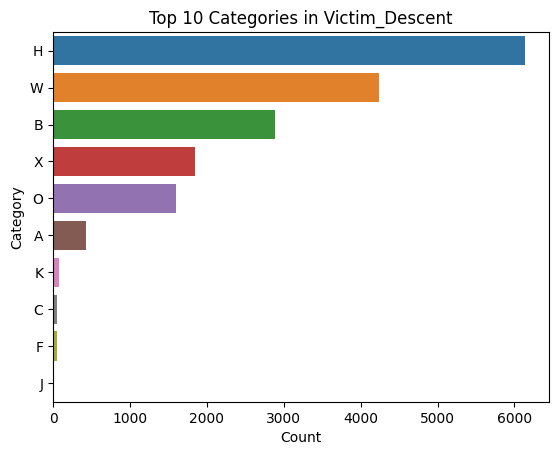

[5033 3379 2491 1437  978  916  679  437  386  267]
Index(['STREET', 'SINGLE FAMILY DWELLING',
       'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)', 'PARKING LOT',
       'SIDEWALK', 'OTHER BUSINESS', 'VEHICLE, PASSENGER/TRUCK',
       'GARAGE/CARPORT', 'DRIVEWAY', 'PARKING UNDERGROUND/BUILDING'],
      dtype='object', name='Premise_Description')


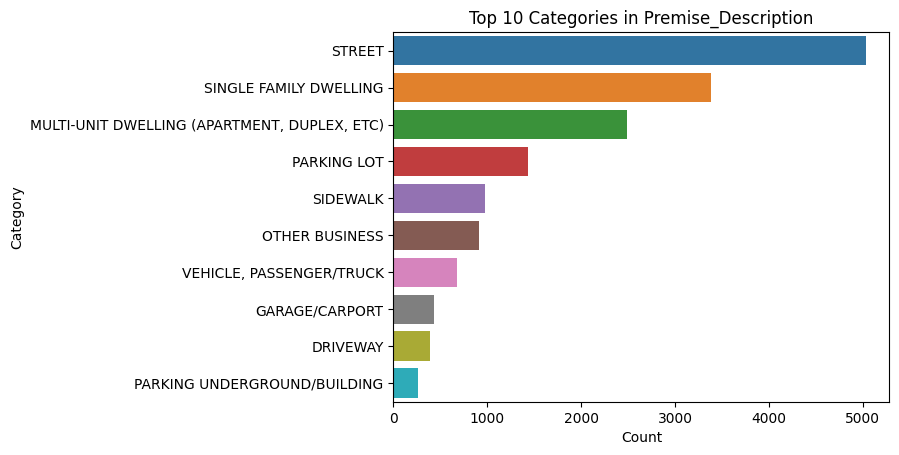

[3990  789  546  388  160  154  131  125   84   80]
Index(['STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
       'UNKNOWN WEAPON/OTHER WEAPON', 'VERBAL THREAT', 'HAND GUN',
       'KNIFE WITH BLADE 6INCHES OR LESS', 'SEMI-AUTOMATIC PISTOL',
       'UNKNOWN FIREARM', 'OTHER KNIFE', 'VEHICLE', 'MACE/PEPPER SPRAY'],
      dtype='object', name='Weapon_Description')


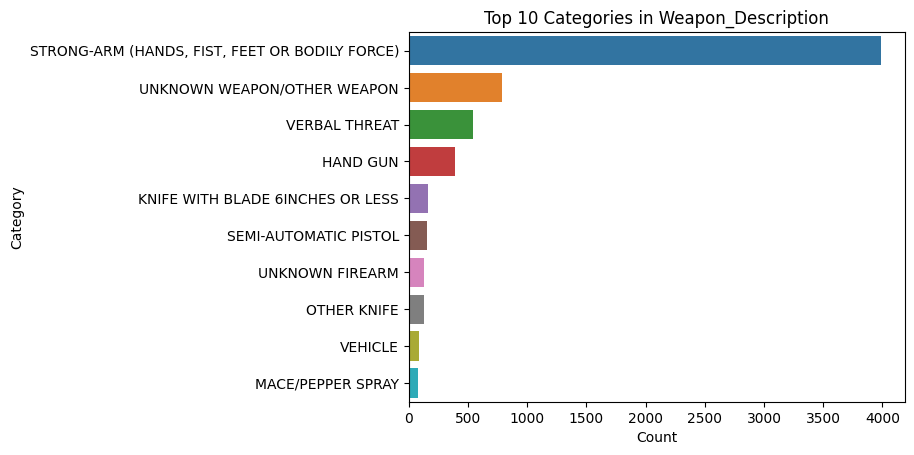

[15236  2597  2054    70    43]
Index(['IC', 'AO', 'AA', 'JA', 'JO'], dtype='object', name='Status')


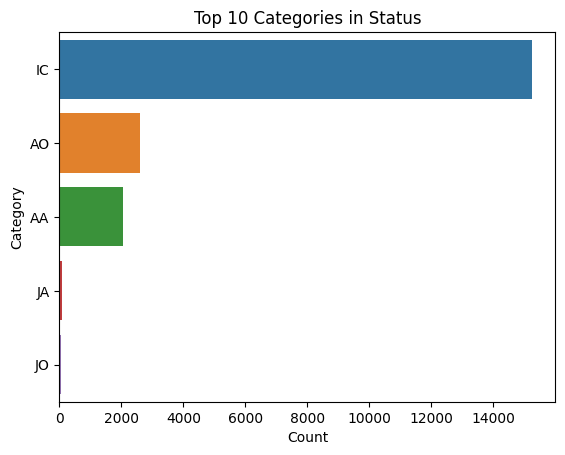

[15236  2597  2054    70    43]
Index(['Invest Cont', 'Adult Other', 'Adult Arrest', 'Juv Arrest',
       'Juv Other'],
      dtype='object', name='Status_Description')


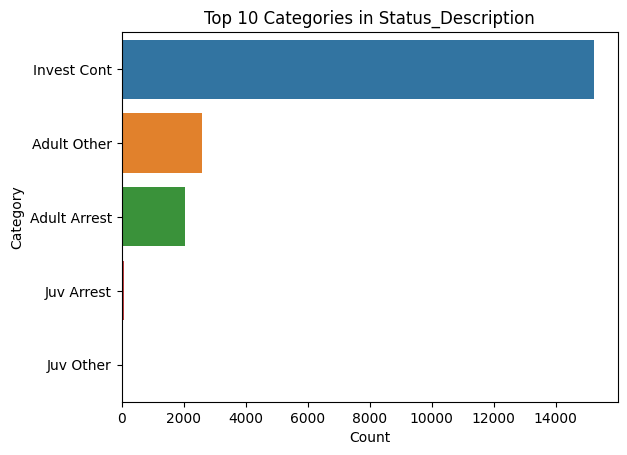

[11666  4767  1808  1355   225   179]
Index(['Property Crimes', 'Violent Crimes', 'Crimes against Public Order',
       'Fraud and White-Collar Crimes', 'Crimes against Persons',
       'Other Crimes'],
      dtype='object', name='Crime_Category')


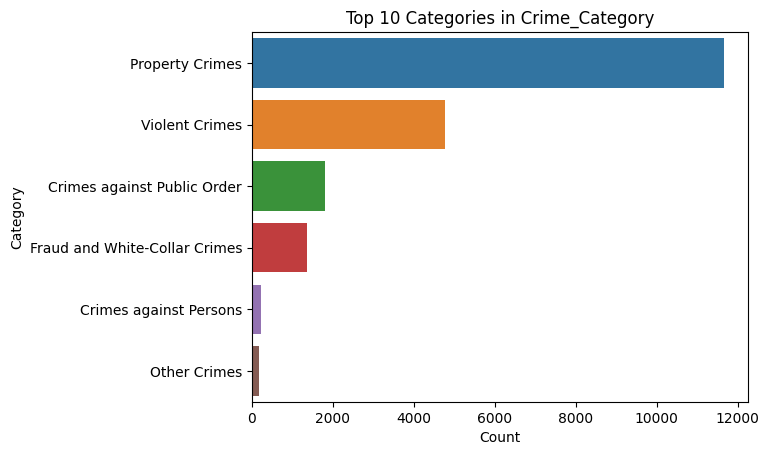

In [13]:
for i, col in enumerate(categorical_cols, 1):
    value_counts = train[col].value_counts().head(10)  # Get top 10 frequent categories
    sns.barplot(x=value_counts.values, y=value_counts.index)
    print(value_counts.values)
    print(value_counts.index)
    plt.title(f'Top 10 Categories in {col}')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.show()

**Observations**

**Location**:
   - There is a high diversity in location data with many unique locations, indicating crimes occur across many different places with no single location dominating.

**Cross_Street**:
   - Cross street data is sparsely populated, suggesting many records do not include this information. However, "BROADWAY" appears relatively frequently among those that do.

**Area_Name**:
   - Area names are less diverse, with 21 unique values, and "77th Street" is the most common, indicating certain areas might have higher crime rates.

**Modus_Operandi**:
   - There is a high variety of methods used in crimes, but some methods are more common than others.

**Victim_Sex**:
   - The majority of victims are male.

**Victim_Descent**:
   - Victim descent is relatively diverse, but "H" (Hispanic) is the most frequent descent category.

**Premise_Description**:
   - Crimes occur in various premises, with "STREET" being the most common.

**Weapon_Description**:
   - Many records lack weapon descriptions, but among those provided, physical force is the most common weapon.

**Status**:
   - The "IC" status ("Invest Cont" - Investigation Continued) is the most common status, suggesting many cases remain under investigation.

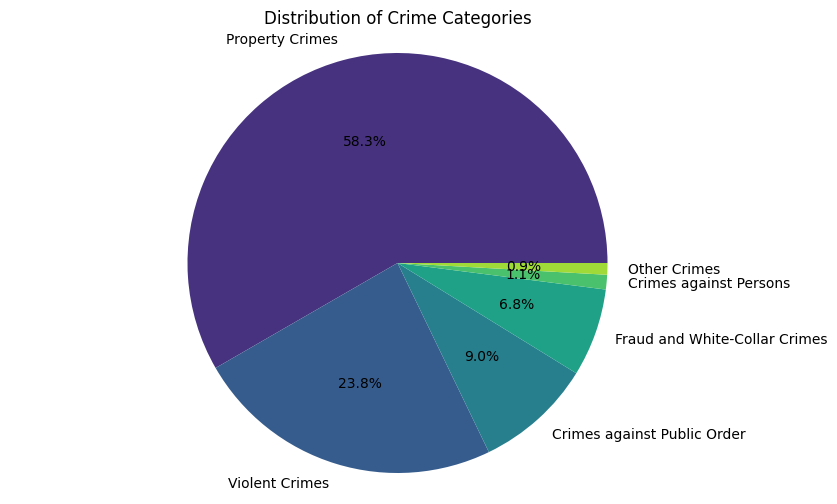

In [14]:
crime_counts = train['Crime_Category'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(crime_counts, labels=crime_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(crime_counts)))
plt.title('Distribution of Crime Categories')
plt.axis('equal')
plt.show()


**Crime_Category**:
   - "Property Crimes" are the most frequently reported category, significantly higher than other types of crimes.

## Data Cleaning <a class="anchor"  id="cleaning"></a>

In [15]:
def remove_whitespaces(df):
    df['Location'] = df['Location'].str.strip() 
    df['Location'] = df['Location'].str.replace(r'\s+', ' ', regex=True)
    df['Cross_Street'] = df['Cross_Street'].str.strip() 
    df['Cross_Street'] = df['Cross_Street'].str.replace(r'\s+', ' ', regex=True)
    return df

In [16]:
train=remove_whitespaces(train)

**Replace outliers and erroneous values in the `Latitude`, `Longitude`, and `Victim_Age` columns with NaN**

In [17]:
def lat_lon(df):
    df.loc[df['Latitude'] == 0, 'Latitude'] = np.nan
    df.loc[df['Longitude'] == 0, 'Longitude'] = np.nan
    df.loc[df['Victim_Age'] < 1, 'Victim_Age'] = np.nan
    return df

In [18]:
train=lat_lon(train)

**Extract information from datetime columns**

In [19]:
def duration_between(df):
    # Convert date columns to datetime format
    date_format = '%m/%d/%Y %I:%M:%S %p'
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'],format=date_format, errors='coerce')
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'],format=date_format, errors='coerce')
    # extract year, month, day
    df['Year_Reported'] = df['Date_Reported'].dt.year
    df['Month_Reported'] = df['Date_Reported'].dt.month
    df['Day_Reported'] = df['Date_Reported'].dt.day
    df['Year_Occurred'] = df['Date_Occurred'].dt.year
    df['Month_Occurred'] = df['Date_Occurred'].dt.month
    df['Day_Occurred'] = df['Date_Occurred'].dt.day
    # Calculate duration in days between date occurred and date reported
    df['Duration_Days'] = (df['Date_Reported'] - df['Date_Occurred']).dt.days
    return df

In [20]:
train=duration_between(train)
train['Duration_Days'].value_counts()

Duration_Days
0      10226
1       4269
2       1136
3        643
4        376
       ...  
340        1
994        1
698        1
100        1
403        1
Name: count, Length: 591, dtype: int64

**Impute missing values in the `Latitude` and `Longitude` columns with the mean of the respective columns**

In [21]:
def impute_lat_lon(df):
    imputer = SimpleImputer(strategy='mean')
    df[['Latitude', 'Longitude']] = imputer.fit_transform(df[['Latitude', 'Longitude']])
    return df

In [22]:
train=impute_lat_lon(train)

**Impute Missing Values in `Cross_Street` column Using KNN**

In [23]:
from sklearn.impute import KNNImputer
def impute_cross_street(df):
    # Encode the categorical column as integers
    label_encoder = LabelEncoder()
    df['Cross_Street_Encoded'] = label_encoder.fit_transform(df['Cross_Street'].astype(str))

    # Select features for imputation
    features = ['Cross_Street_Encoded']
    
    # Apply KNN imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df[features] = knn_imputer.fit_transform(df[features])

    # Decode the integers back to strings
    df['Cross_Street'] = label_encoder.inverse_transform(df['Cross_Street_Encoded'].astype(int))
    
    # Drop the temporary encoded column
    df = df.drop(columns=['Cross_Street_Encoded'])
    
    return df

In [24]:
train=impute_cross_street(train)

#### Drop the `Area_Code` Column
Since `Area_Code` and `Area_Name` represent the same information, drop the `Area_Code` column.
Similarly, drop the `Premise_Description`, `Weapon_Description`, and `Status_Description` columns as they are no longer needed.

#### Drop Date Columns
Additionally, drop the `Date_Reported` and `Date_Occurred` columns since useful information has already been extracted from these columns and updated in the dataset.

In [25]:
def drop_col(df):
    df=df.drop(columns=['Area_Name','Premise_Description','Weapon_Description','Status_Description','Date_Reported','Date_Occurred'])
    return df

In [26]:
train=drop_col(train)

In [27]:
train['Victim_Sex'].value_counts()

Victim_Sex
M    8538
F    7176
X    1660
H       2
Name: count, dtype: int64

### Handling Anomalies and Missing Values in `Victim_Sex`
**Issue with `H`:**  
The value `H` is identified as an anomaly, as it does not conform to the expected categories of gender. To maintain consistency, we will replace `H` with `X`.

**Steps for Handling `X` and Missing Values:**

1. **Replace Anomalous Values:**
   - We will replace the anomalous value `H` with `X`. This is because `X` is a predefined category representing unknown genders, which aligns better with the dataset's intent.
2. **Consider `X` as a Valid Category:**
   - After replacing `H` with `X`, we will treat `X` as a valid category within the `Victim_Sex` column. This ensures that all data entries are categorized consistently.

3. **Impute Missing Values with `X`:**
   - We will replace  the missing values with `X`. This ensures that we have no missing values and all records are filled with a reasonable default category.

In [28]:
train['Victim_Descent'].value_counts()

Victim_Descent
H    6143
W    4245
B    2881
X    1849
O    1603
A     427
K      83
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: count, dtype: int64

### Handling and Replacing Values in the `Victim_Descent` Column

1. **Consolidate All Categories except Most Frequent Ones into `O`:**
   - To simplify the dataset and handle less frequent categories more effectively, we will consolidate all categories into a single `'O'` category, which represents "Other." This includes all the categories except the most frequent ones (`H`, `W`, `B`, `X`). 

2. **Replace Missing Values:**
   - We then will replace any missing values (`NaN`) in the `Victim_Descent` column with `'X'`. This assigns a placeholder for cases where the descent information is not specified, ensuring that there are no missing values in the column.

In [29]:
def victim_sex_descent_age(df):
    df['Victim_Sex'] = df['Victim_Sex'].replace('H', 'X')
    df['Victim_Sex'] = df['Victim_Sex'].replace(np.nan, 'X')
    categories_to_replace = ['K', 'C', 'F', 'J', 'I', 'V', 'P', 'Z', 'U', 'D', 'G']
    df['Victim_Descent'] = df['Victim_Descent'].replace(categories_to_replace, 'O')
    df['Victim_Descent'] = df['Victim_Descent'].replace(np.nan, 'X')
    imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform the Age column
    df['Victim_Age'] = imputer.fit_transform(df[['Victim_Age']])
    return df

In [30]:
train=victim_sex_descent_age(train)

**Impute the missing values in `Weapon_Used_Code` with the most frequent value**

In [31]:
train['Weapon_Used_Code'] = train['Weapon_Used_Code'].fillna(train['Weapon_Used_Code'].mode()[0])

### `Modus_Operandi` Column

**Data Preparation:** The `Modus_Operandi` column will be transformed into a numerical format using `MultiLabelBinarizer`, making it suitable for machine learning models.

**Binary Matrix:** The text data will be converted into a binary matrix where each unique label will be represented by a separate column.

**Data Integration:** The transformed data will be integrated back into the training DataFrame, replacing the original column with a format that will be compatible with machine learning algorithms.

In [32]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._label")

# Define and fit MultiLabelBinarizer on the training data
mlb = MultiLabelBinarizer()
mlb.fit(train['Modus_Operandi'].apply(lambda x: x.split() if isinstance(x, str) else []))

# Transform the Modus_Operandi column
train_mo = mlb.transform(train['Modus_Operandi'].apply(lambda x: x.split() if isinstance(x, str) else []))

# Convert the transformed data back to DataFrames
train_mo_df = pd.DataFrame(train_mo, columns=mlb.classes_)

# Drop the original Modus_Operandi column and concatenate the transformed columns
train = train.drop(columns=['Modus_Operandi']).reset_index(drop=True)

train = pd.concat([train, train_mo_df], axis=1)

In [33]:
train.isnull().sum().sum()

0

## Preprocessing Pipeline <a class="anchor"  id="pipe"></a>

In [34]:
x = train.drop(columns=['Crime_Category'])  # Features
y = train['Crime_Category']  # Target variable

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [36]:
label_encoder=LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [37]:
num_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = x_train.select_dtypes(include=['object', 'category','string']).columns.tolist()
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])
# Combine the pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([

    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
   
])
pca = PCA(n_components=0.95) 

## MODEL-1 XGBOOST <a class="anchor"  id="model1"></a>

**FINETUNING**

In [38]:
"""# Define the XGBClassifier model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the pipeline with preprocessing and model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', xgb)
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=param_grid, 
    n_iter=20,  # Number of parameter settings to sample
    cv=3, 
    verbose=4, 
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the random search to the training data
random_search.fit(x_train, y_train_encoded)"""

"# Define the XGBClassifier model\nxgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')\n\n# Define the pipeline with preprocessing and model\nmodel_pipeline = Pipeline([\n    ('preprocessor', preprocessor),\n    ('pca', pca),\n    ('classifier', xgb)\n])\n\n# Define hyperparameter grid\nparam_grid = {\n    'classifier__n_estimators': [100, 200, 300, 400, 500],\n    'classifier__max_depth': [3, 4, 5, 6, 7, 8],\n    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],\n    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],\n    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]\n}\n\n# Create RandomizedSearchCV object\nrandom_search = RandomizedSearchCV(\n    model_pipeline, \n    param_distributions=param_grid, \n    n_iter=20,  # Number of parameter settings to sample\n    cv=3, \n    verbose=4, \n    n_jobs=-1,  # Use all available cores\n    random_state=42\n)\n\n# Fit the random search to the training data\nrandom_search.fit(x_train, y_train_encoded)"

In [39]:
#best_params = random_search.best_params_
#print(f"Best parameters found: {best_params}")

In [40]:
# Create a complete pipeline with preprocessing and model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('pca', pca),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss',subsample=0.9, 
                                 n_estimators=300,max_depth=4,learning_rate=0.2, colsample_bytree=0.7))
])

# Train the model
model_pipeline.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Time_Occurred', 'Area_ID',
                                                   'Reporting_District_no',
                                                   'Part 1-2', 'Victim_Age',
                                                   'Premise_Code',
                                                   'Weapon_Used_Code',
                                                   'Duration_Days', '0100',
                                                   '0104', '0105', '0110',
                                                   '0112', '0113', '0114',
                                                   '0115', '0117', '0120',
                                                   '0121', '0200', '0...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [41]:
# Predict on the validation set
y_pred_xgb = model_pipeline.predict(x_val)

# Decode the predicted labels back to original labels
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_val, y_pred_xgb_decoded)
print(f"XGBoost validation accuracy: {xgb_accuracy:.4f}")

XGBoost validation accuracy: 0.9560


In [42]:
print(classification_report(y_val,y_pred_xgb_decoded))

                               precision    recall  f1-score   support

       Crimes against Persons       0.68      0.72      0.70        32
  Crimes against Public Order       0.84      0.87      0.86       374
Fraud and White-Collar Crimes       0.97      0.94      0.96       267
                 Other Crimes       0.53      0.23      0.32        35
              Property Crimes       0.99      0.99      0.99      2303
               Violent Crimes       0.93      0.95      0.94       989

                     accuracy                           0.96      4000
                    macro avg       0.82      0.78      0.79      4000
                 weighted avg       0.95      0.96      0.95      4000



In [43]:
# XGBOOST MODEL PERFORMANCE
y_pred_xgb = model_pipeline.predict(x_val)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)
xgb_accuracy = accuracy_score(y_val, y_pred_xgb_decoded)
xgb_precision = precision_score(y_val,y_pred_xgb_decoded, average='weighted')
xgb_recall = recall_score(y_val,y_pred_xgb_decoded, average='weighted')
xgb_f1 = f1_score(y_val,y_pred_xgb_decoded, average='weighted')

## MODEL-2 RANDOM FOREST <a class="anchor"  id="model2"></a>

In [44]:
"""# Define the RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# Define the pipeline with preprocessing and model
model_pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', rf)
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create RandomizedSearchCV object
random_search1 = RandomizedSearchCV(
    model_pipeline1, 
    param_distributions=param_grid, 
    n_iter=20,  # Number of parameter settings to sample
    cv=3, 
    verbose=4, 
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the random search to the training data
random_search1.fit(x_train, y_train_encoded)"""

"# Define the RandomForestClassifier model\nrf = RandomForestClassifier(random_state=42)\n\n# Define the pipeline with preprocessing and model\nmodel_pipeline1 = Pipeline([\n    ('preprocessor', preprocessor),\n    ('pca', pca),\n    ('classifier', rf)\n])\n\n# Define hyperparameter grid\nparam_grid = {\n    'classifier__n_estimators': [100, 200, 300, 400, 500],\n    'classifier__max_features': ['sqrt', 'log2'],\n    'classifier__max_depth': [None, 10, 20, 30, 40, 50],\n    'classifier__min_samples_split': [2, 5, 10],\n    'classifier__min_samples_leaf': [1, 2, 4],\n    'classifier__bootstrap': [True, False]\n}\n\n# Create RandomizedSearchCV object\nrandom_search1 = RandomizedSearchCV(\n    model_pipeline1, \n    param_distributions=param_grid, \n    n_iter=20,  # Number of parameter settings to sample\n    cv=3, \n    verbose=4, \n    n_jobs=-1,  # Use all available cores\n    random_state=42\n)\n\n# Fit the random search to the training data\nrandom_search1.fit(x_train, y_train_encod

In [45]:
#best_params1 = random_search1.best_params_
#print(f"Best parameters found: {best_params1}")

In [46]:
# Define the RandomForestClassifier with the specified parameters
rf = RandomForestClassifier(
    n_estimators=400,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

model_pipeline1= Pipeline([
    ('preprocessor', preprocessor),
    #('pca', pca),
    ('classifier',rf)
])

# Train the model
model_pipeline1.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Time_Occurred', 'Area_ID',
                                                   'Reporting_District_no',
                                                   'Part 1-2', 'Victim_Age',
                                                   'Premise_Code',
                                                   'Weapon_Used_Code',
                                                   'Duration_Days', '0100',
                                                   '0104', '0105', '0110',
                                                   '0112', '0113', '0114',
                                                   '0115', '0117', '0120',
                                                   '0121', '0200', '0201',
                                                   '0202', '0206', '0207',
                                                   '0209', '0210', '0211',
                                                   '0212', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Location', 'Cross_Street',
                                                   'Victim_Sex',
                                                   'Victim_Descent',
                                                   'Status'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, min_samples_split=5,
                                        n_estimators=400, random_state=42))])

In [47]:
#RANDOM FOREST PERFORMANCE
y_pred_rf = model_pipeline1.predict(x_val)
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)
rf_accuracy = accuracy_score(y_val, y_pred_rf_decoded)
rf_precision = precision_score(y_val,y_pred_rf_decoded, average='weighted')
rf_recall = recall_score(y_val,y_pred_rf_decoded, average='weighted')
rf_f1 = f1_score(y_val,y_pred_rf_decoded, average='weighted')

## MODEL-3 SVM <a class="anchor"  id="model3"></a>

In [48]:
"""# Define the SVC model
svc = SVC()

# Define the pipeline with preprocessing and model
model_pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', svc)
])

# Define hyperparameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

# Create RandomizedSearchCV object
random_search2 = RandomizedSearchCV(
    model_pipeline2, 
    param_distributions=param_grid, 
    n_iter=20,  # Number of parameter settings to sample
    cv=3, 
    verbose=4, 
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the random search to the training data
random_search2.fit(x_train, y_train_encoded)"""

"# Define the SVC model\nsvc = SVC()\n\n# Define the pipeline with preprocessing and model\nmodel_pipeline2 = Pipeline([\n    ('preprocessor', preprocessor),\n    ('pca', pca),\n    ('classifier', svc)\n])\n\n# Define hyperparameter grid\nparam_grid = {\n    'classifier__C': [0.1, 1, 10, 100, 1000],\n    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],\n    'classifier__kernel': ['rbf', 'poly', 'sigmoid']\n}\n\n# Create RandomizedSearchCV object\nrandom_search2 = RandomizedSearchCV(\n    model_pipeline2, \n    param_distributions=param_grid, \n    n_iter=20,  # Number of parameter settings to sample\n    cv=3, \n    verbose=4, \n    n_jobs=-1,  # Use all available cores\n    random_state=42\n)\n\n# Fit the random search to the training data\nrandom_search2.fit(x_train, y_train_encoded)"

In [49]:
#best_params = random_search2.best_params_
#print(f"Best parameters found: {best_params}")

In [50]:
model_pipeline2= Pipeline([
    ('preprocessor', preprocessor),
    #('pca', pca),
    ('classifier', SVC(
        kernel= 'rbf',gamma= 0.0001,C=10, 
        random_state=42
    ))
])

# Train the model
model_pipeline2.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Time_Occurred', 'Area_ID',
                                                   'Reporting_District_no',
                                                   'Part 1-2', 'Victim_Age',
                                                   'Premise_Code',
                                                   'Weapon_Used_Code',
                                                   'Duration_Days', '0100',
                                                   '0104', '0105', '0110',
                                                   '0112', '0113', '0114',
                                                   '0115', '0117', '0120',
                                                   '0121', '0200', '0201',
                                                   '0202', '0206', '0207',
                                                   '0209', '0210', '0211',
                                                   '0212', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Location', 'Cross_Street',
                                                   'Victim_Sex',
                                                   'Victim_Descent',
                                                   'Status'])])),
                ('classifier', SVC(C=10, gamma=0.0001, random_state=42))])

In [51]:
#SVM Tree Predictions
y_pred_svm = model_pipeline2.predict(x_val)
y_pred_svm_decoded = label_encoder.inverse_transform(y_pred_svm)
svm_accuracy = accuracy_score(y_val, y_pred_svm_decoded)
svm_precision = precision_score(y_val,y_pred_svm_decoded, average='weighted')
svm_recall = recall_score(y_val,y_pred_svm_decoded, average='weighted')
svm_f1 = f1_score(y_val,y_pred_svm_decoded, average='weighted')

## MODEL-4 DECISION TREE CLASSIFIER <a class="anchor"  id="model4"></a>

In [52]:
"""# Define the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Create the full pipeline with preprocessing and the Decision Tree classifier
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', dt)
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__max_depth': [3,5,7,10, None],
    'classifier__min_samples_split': [2,5,10,15,20],
    'classifier__min_samples_leaf': [2,5,10,15,20],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up the RandomizedSearchCV
random_search3 = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, 
                                   n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search3.fit(x_train, y_train_encoded)"""

"# Define the Decision Tree classifier\ndt = DecisionTreeClassifier(random_state=42)\n\n# Create the full pipeline with preprocessing and the Decision Tree classifier\nmodel_pipeline = Pipeline([\n    ('preprocessor', preprocessor),\n    ('pca', pca),\n    ('classifier', dt)\n])\n\n# Define the hyperparameter grid for RandomizedSearchCV\nparam_dist = {\n    'classifier__max_depth': [3,5,7,10, None],\n    'classifier__min_samples_split': [2,5,10,15,20],\n    'classifier__min_samples_leaf': [2,5,10,15,20],\n    'classifier__criterion': ['gini', 'entropy']\n}\n\n# Set up the RandomizedSearchCV\nrandom_search3 = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, \n                                   n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)\nrandom_search3.fit(x_train, y_train_encoded)"

In [53]:
#best_params = random_search3.best_params_
#print(f"Best parameters found: {best_params}")

In [54]:
#best_model = random_search3.best_estimator_

In [55]:
dt=DecisionTreeClassifier(random_state=42,min_samples_split=20,min_samples_leaf=2,max_depth=None,criterion='gini')
model_pipeline3= Pipeline([
    ('preprocessor', preprocessor),
    #('pca', pca),
    ('classifier',dt)
])

# Train the model
model_pipeline3.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Time_Occurred', 'Area_ID',
                                                   'Reporting_District_no',
                                                   'Part 1-2', 'Victim_Age',
                                                   'Premise_Code',
                                                   'Weapon_Used_Code',
                                                   'Duration_Days', '0100',
                                                   '0104', '0105', '0110',
                                                   '0112', '0113', '0114',
                                                   '0115', '0117', '0120',
                                                   '0121', '0200', '0201',
                                                   '0202', '0206', '0207',
                                                   '0209', '0210', '0211',
                                                   '0212', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Location', 'Cross_Street',
                                                   'Victim_Sex',
                                                   'Victim_Descent',
                                                   'Status'])])),
                ('classifier',
                 DecisionTreeClassifier(min_samples_leaf=2,
                                        min_samples_split=20,
                                        random_state=42))])

In [56]:
#Decision Tree Predictions
y_pred_dt = model_pipeline3.predict(x_val)
y_pred_dt_decoded = label_encoder.inverse_transform(y_pred_dt)
dt_accuracy = accuracy_score(y_val, y_pred_dt_decoded)
dt_precision = precision_score(y_val,y_pred_dt_decoded, average='weighted')
dt_recall = recall_score(y_val,y_pred_dt_decoded, average='weighted')
dt_f1 = f1_score(y_val,y_pred_dt_decoded, average='weighted')

## Model Comparison and Results <a class="anchor"  id="comparison"></a>

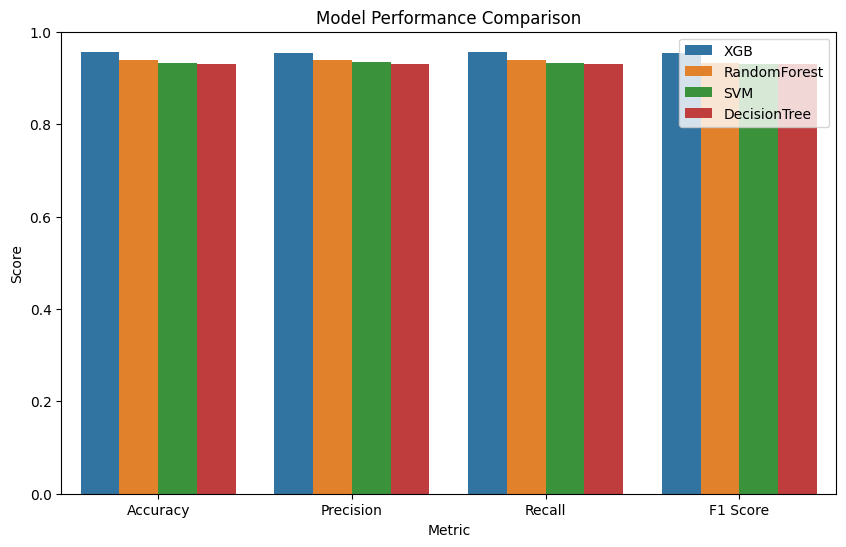

In [57]:
# Visualization of model performance
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'XGB': [xgb_accuracy,xgb_precision, xgb_recall, xgb_f1],
    'RandomForest': [rf_accuracy, rf_precision, rf_recall, rf_f1],
    'SVM': [svm_accuracy, svm_precision, svm_recall, svm_f1],
    'DecisionTree': [dt_accuracy, dt_precision, dt_recall, dt_f1]
})

# Melt the DataFrame for seaborn
metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Plotting the metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()




Here is a comparative analysis of the four models based on their performance metrics:

#### **XGB MODEL**
- **Accuracy:** 0.96
- **Precision:** 
  - Highest for "Property Crimes" (0.99)
  - Lowest for "Other Crimes" (0.42)
- **Recall:**
  - Highest for "Property Crimes" (0.99)
  - Lowest for "Other Crimes" (0.23)
- **F1-Score:**
  - Highest for "Property Crimes" (0.99)
  - Lowest for "Other Crimes" (0.30)
- **Macro Average:**
  - Precision: 0.80
  - Recall: 0.77
  - F1-Score: 0.78
- **Weighted Average:**
  - Precision: 0.95
  - Recall: 0.96
  - F1-Score: 0.96

**Observations:**
- Model 1 achieves the highest overall accuracy (0.96) and performs very well in terms of precision and recall for most categories, particularly "Property Crimes."
- However, it struggles with "Other Crimes," where both precision and recall are low.

#### **RANDOM FOREST**
- **Accuracy:** 0.94
- **Precision:** 
  - Highest for "Other Crimes" (1.00)
  - Lowest for "Crimes against Persons" (0.73)
- **Recall:**
  - Highest for "Violent Crimes" (0.97)
  - Lowest for "Other Crimes" (0.03)
- **F1-Score:**
  - Highest for "Fraud and White-Collar Crimes" (0.94)
  - Lowest for "Other Crimes" (0.06)
- **Macro Average:**
  - Precision: 0.91
  - Recall: 0.65
  - F1-Score: 0.68
- **Weighted Average:**
  - Precision: 0.94
  - Recall: 0.94
  - F1-Score: 0.93

**Observations:**
- Model 2 has a good overall accuracy (0.94) and performs well for most categories but shows extremely low recall for "Other Crimes."
- The precision for "Other Crimes" is perfect, but the recall is very poor, indicating it misses many of these instances.

#### **SVM**
- **Accuracy:** 0.93
- **Precision:** 
  - Highest for "Fraud and White-Collar Crimes" (0.98)
  - Lowest for "Crimes against Persons" (0.38)
- **Recall:**
  - Highest for "Violent Crimes" (0.92)
  - Lowest for "Other Crimes" (0.09)
- **F1-Score:**
  - Highest for "Fraud and White-Collar Crimes" (0.92)
  - Lowest for "Other Crimes" (0.15)
- **Macro Average:**
  - Precision: 0.77
  - Recall: 0.70
  - F1-Score: 0.70
- **Weighted Average:**
  - Precision: 0.93
  - Recall: 0.93
  - F1-Score: 0.93

**Observations:**
- Model 3 achieves a slightly lower accuracy (0.93) compared to Model 1 and Model 2.
- It has strong performance in "Fraud and White-Collar Crimes" and "Violent Crimes," but weak performance in "Crimes against Persons" and "Other Crimes."

#### **DECISION TREE**
- **Accuracy:** 0.93
- **Precision:** 
  - Highest for "Property Crimes" (0.98)
  - Lowest for "Other Crimes" (0.40)
- **Recall:**
  - Highest for "Property Crimes" (0.98)
  - Lowest for "Other Crimes" (0.29)
- **F1-Score:**
  - Highest for "Fraud and White-Collar Crimes" (0.90)
  - Lowest for "Other Crimes" (0.33)
- **Macro Average:**
  - Precision: 0.75
  - Recall: 0.76
  - F1-Score: 0.75
- **Weighted Average:**
  - Precision: 0.93
  - Recall: 0.93
  - F1-Score: 0.93

**Observations:**
- Model 4 also achieves an accuracy of 0.93.
- It performs well for "Property Crimes" and "Fraud and White-Collar Crimes," but like the other models, it struggles with "Other Crimes."

### Summary

- **Best Overall Performance:** **XGB** has the highest accuracy and overall performance metrics, especially for "Property Crimes."
- **Best for Specific Categories:** **RANDOM FOREST** excels in precision but has a significant recall issue for "Other Crimes." **SVM** and **DECISION TREE** also show strong performance but have similar issues with "Other Crimes."
- **Areas for Improvement:** All models have difficulty with the "Other Crimes" category, indicating a need for further refinement or additional data to improve classification in this category.

## Prepare Test Data <a class="anchor"  id="test"></a>

In [58]:
test.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [59]:
test=remove_whitespaces(test)

In [60]:
test=lat_lon(test)

In [61]:
test=duration_between(test)

In [62]:
test=impute_lat_lon(test)

In [63]:
test=impute_cross_street(test)

In [64]:
test=drop_col(test)

In [65]:
test=victim_sex_descent_age(test)

In [66]:
test['Weapon_Used_Code'] = test['Weapon_Used_Code'].fillna(test['Weapon_Used_Code'].mode()[0])

In [67]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._label")
test_mo = mlb.transform(test['Modus_Operandi'].apply(lambda x: x.split() if isinstance(x, str) else []))
test_mo_df = pd.DataFrame(test_mo, columns=mlb.classes_)
test = test.drop(columns=['Modus_Operandi']).reset_index(drop=True)
test = pd.concat([test, test_mo_df], axis=1)

In [68]:
test.isnull().sum().sum()

0

## Test Prediction and Submission <a class="anchor"  id="submission"></a>

In [69]:
y_test_pred=model_pipeline.predict(test)
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
y_test_pred_decoded

array(['Violent Crimes', 'Property Crimes',
       'Fraud and White-Collar Crimes', ..., 'Violent Crimes',
       'Violent Crimes', 'Property Crimes'], dtype=object)

In [70]:
submission = pd.DataFrame({"ID": np.arange(1,5001), 
                           "Crime_Category": y_test_pred_decoded,
                          }
                         ) 

submission.to_csv('submission.csv',index=False)